In [1]:
import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from tensorflow import keras
import yfinance as yf
plt.style.use('fivethirtyeight')


2023-01-24 17:15:02.393470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Get the stock quote, with the date as integer index
df = yf.download('AAPL', start='2012-01-01', end='2019-12-17')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03 00:00:00-05:00,14.621429,14.732143,14.607143,14.686786,12.519279,302220800
2012-01-04 00:00:00-05:00,14.642857,14.810000,14.617143,14.765714,12.586555,260022000
2012-01-05 00:00:00-05:00,14.819643,14.948214,14.738214,14.929643,12.726292,271269600
2012-01-06 00:00:00-05:00,14.991786,15.098214,14.972143,15.085714,12.859332,318292800
2012-01-09 00:00:00-05:00,15.196429,15.276786,15.048214,15.061786,12.838937,394024400
...,...,...,...,...,...,...
2019-12-10 00:00:00-05:00,67.150002,67.517502,66.464996,67.120003,65.755959,90420400
2019-12-11 00:00:00-05:00,67.202499,67.775002,67.125000,67.692497,66.316811,78756800
2019-12-12 00:00:00-05:00,66.945000,68.139999,66.830002,67.864998,66.485809,137310400


In [18]:
# Get the number of rows and columns in the data set
df.shape

(2002, 6)

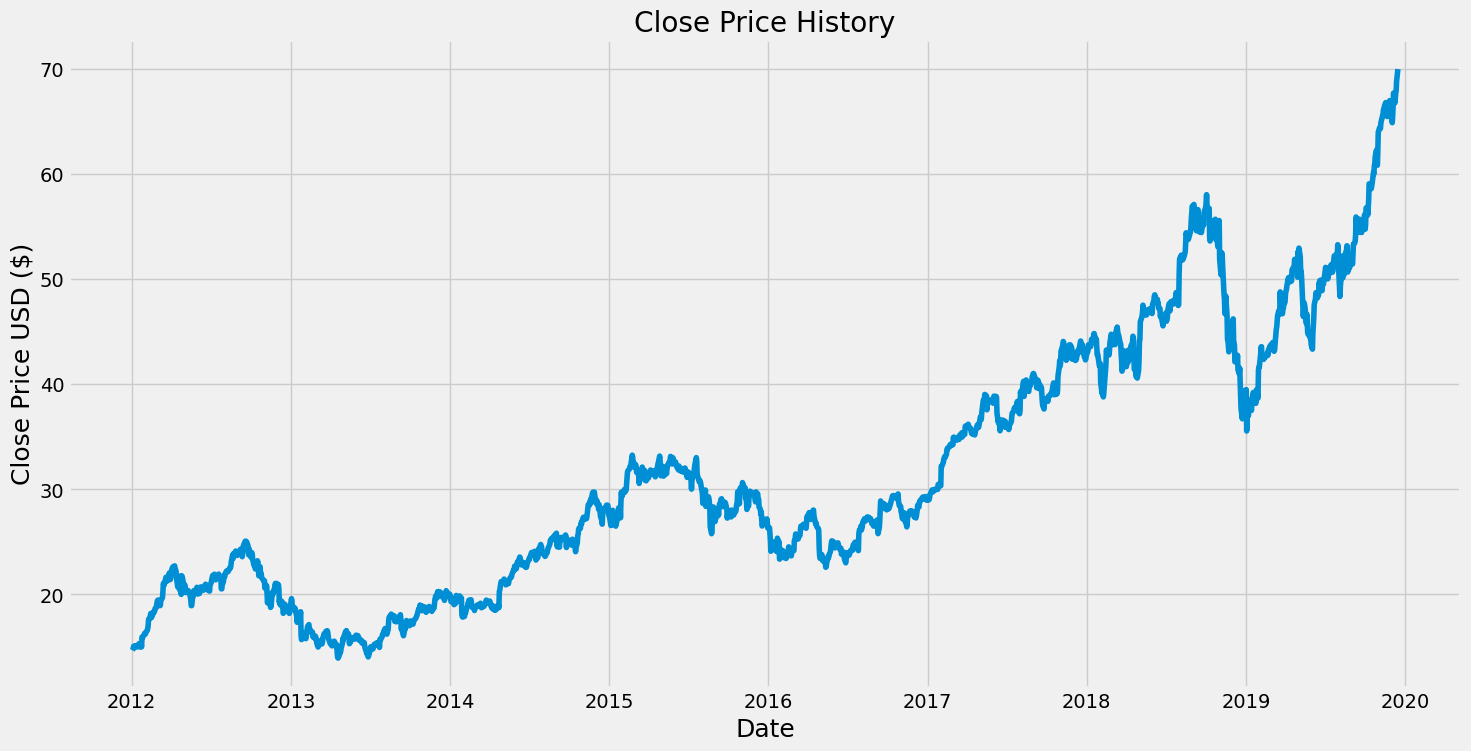

In [19]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [20]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

training_data_len

1602

In [21]:
#Scale the all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0131974 ],
       [0.01460639],
       [0.01753278],
       ...,
       [0.96251174],
       [0.97897982],
       [1.        ]])

In [22]:
# Create the scaled training data set
train_data = scaled_data[0:training_data_len  , : ]
# Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.0131974 , 0.01460639, 0.01753278, 0.0203189 , 0.01989174,
       0.02085445, 0.02041453, 0.01967497, 0.01866762, 0.02178528,
       0.02459691, 0.02372983, 0.01898002, 0.02351306, 0.01905016,
       0.03578601, 0.03449178, 0.0361813 , 0.03983449, 0.0420468 ,
       0.04186191, 0.04117973, 0.04408699, 0.04682209, 0.04992063,
       0.05492545, 0.06543874, 0.06559812, 0.0714509 , 0.07582451,
       0.06830775, 0.07120224, 0.07114487, 0.07926096, 0.07810697,
       0.08024277, 0.08408086, 0.08621669, 0.0923691 , 0.0968511 ,
       0.09814534, 0.09859802, 0.09093461, 0.08908567, 0.08935984,
       0.09656423, 0.09859166, 0.10294617, 0.1132108 , 0.12690551,
       0.12434252, 0.12434889, 0.13425015, 0.13734869, 0.13514271,
       0.13312806, 0.13103049, 0.13799896, 0.14278065, 0.14478257])]
[0.139835129205152]

[array([0.0131974 , 0.01460639, 0.01753278, 0.0203189 , 0.01989174,
       0.02085445, 0.02041453, 0.01967497, 0.01866762, 0.02178528,
       0.02459691, 0.02372983, 0.0189

In [23]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1542, 60, 1)

In [24]:
# Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


2023-01-22 23:01:34.949634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
# Compiling the RNN
model.compile(
    optimizer= 'adam',
    loss = 'mean_squared_error',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Train the model
history_model=model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=False)

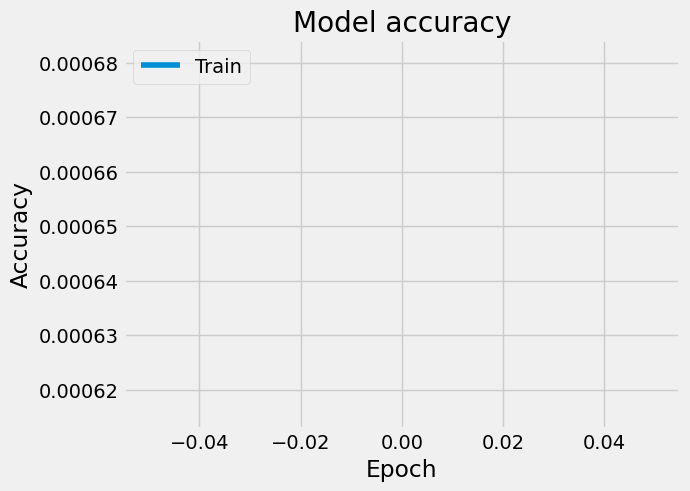

In [58]:
# Plot training & validation accuracy values
plt.plot(history_model.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

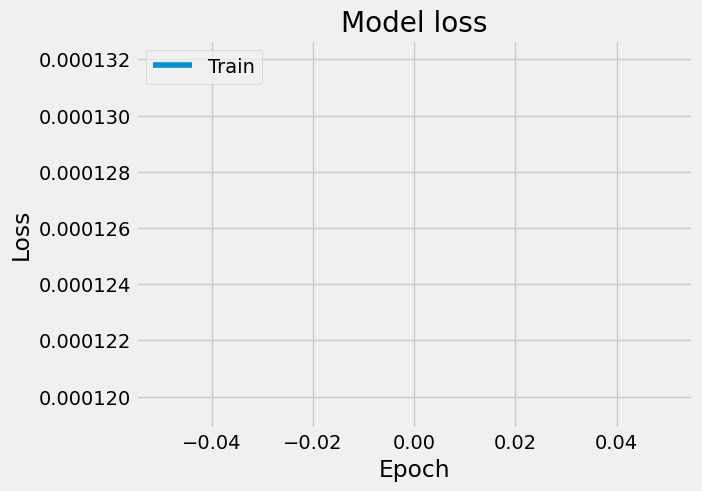

In [59]:
# Plot training & validation loss values
plt.plot(history_model.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

13/13 [==============================] - 0s 9ms/step
RMSE: 4.104688625393413


/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_81809/2098556832.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


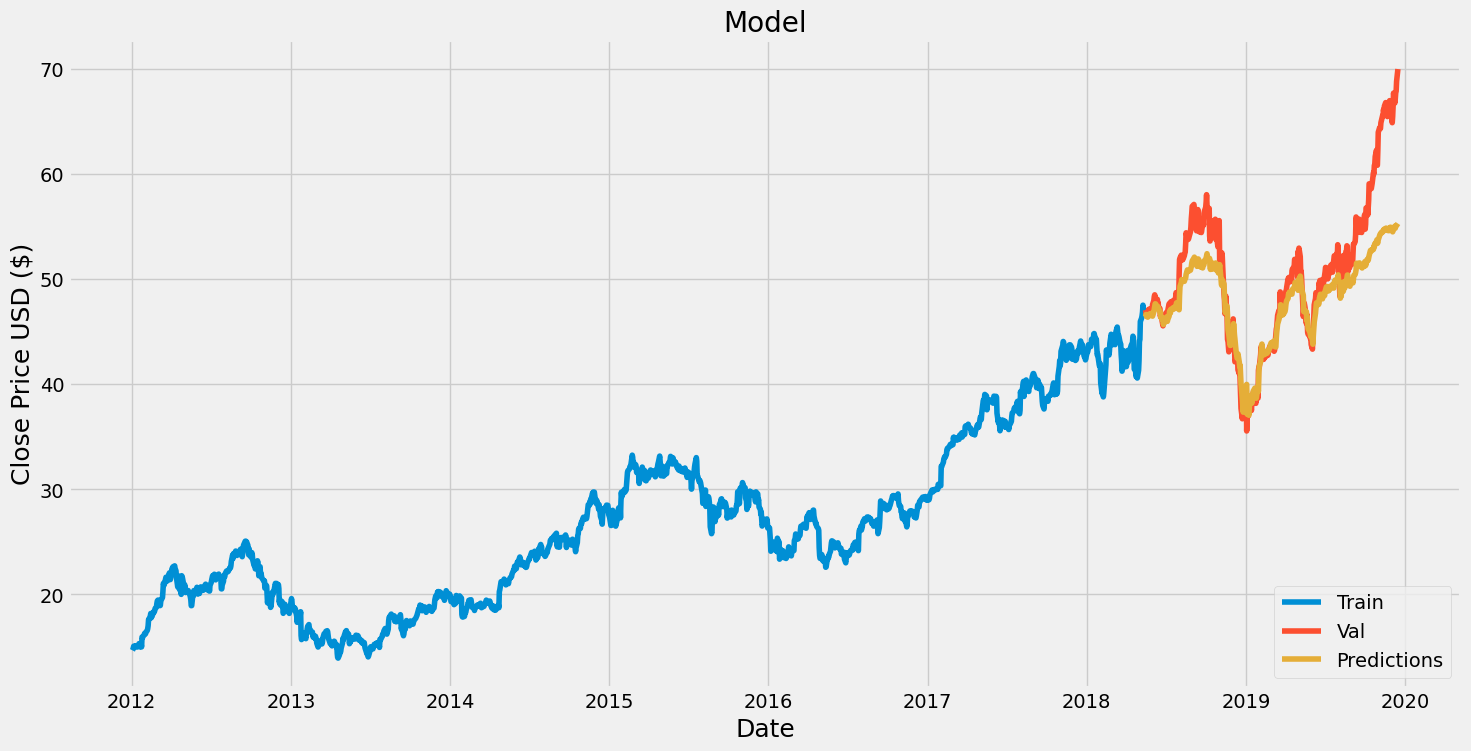

In [61]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , : ]
# Create the data sets x_test and y_test
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
# Convert x_test to a numpy array   
x_test = np.array(x_test)

# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)#Undo scaling

# Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(f'RMSE: {rmse}')

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [62]:
# Show the valid and predicted prices
valid


,Close,Predictions
Date,,
2018-05-16 00:00:00-04:00,47.044998,46.442276
2018-05-17 00:00:00-04:00,46.747501,46.625290
2018-05-18 00:00:00-04:00,46.577499,46.446224
2018-05-21 00:00:00-04:00,46.907501,46.371056
2018-05-22 00:00:00-04:00,46.790001,46.511230
...,...,...
2019-12-10 00:00:00-05:00,67.120003,54.827072
2019-12-11 00:00:00-05:00,67.692497,54.979897
2019-12-12 00:00:00-05:00,67.864998,55.047050


In [64]:
# Get the quote
apple_quote = yf.download('AAPL', start='2012-01-01', end='2019-12-17')
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 23ms/step
[[55.47688]]


In [65]:
# Get the quote
apple_quote2 = yf.download('AAPL', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
Series([], Name: Close, dtype: float64)
